## **Loading Data**
Sebelum melakukan proses loading data, pertama kita import library yang akan digunakan selama training terlebih dahulu. 

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from keras.models import Sequential
from keras.models import Sequential, load_model
from keras.layers import Conv2D, Dense, Flatten, Dropout, MaxPool2D
from sklearn.model_selection import train_test_split
import pickle
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
matplotlib.style.use('ggplot')
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

Kemudian, lakukan mount drive dengan code berikut:

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## **Load Data**

In [4]:
## Load the data
training_file = "/content/drive/MyDrive/Dataset/German Traffic Sign/train.p"
testing_file = "/content/drive/MyDrive/Dataset/German Traffic Sign/test.p"   
 
# Open and load the training file 
with open(training_file, mode='rb') as f:
    train = pickle.load(f)
 
# Open and load the testing file
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
print("Data loaded")

Data loaded


## **Eksplorasi Data**
Tahapan eksplorasi data yang pertama adalah membaca file signnames.csv. File ini berisi id dan nama kelas dataset traffic sign.

In [5]:
## Buat pandas dataframe untuk load data csv
## File csv ini berupa ClassId dan SignName
 
sign_name_df = pd.read_csv('/content/drive/MyDrive/Dataset/German Traffic Sign/signnames.csv')
SIGN_NAMES = sign_name_df.SignName.values
sign_name_df.set_index('ClassId', inplace=True)
sign_name_df.head(10)

,SignName
ClassId,
0,Speed limit (20km/h)
1,Speed limit (30km/h)
2,Speed limit (50km/h)
3,Speed limit (60km/h)
4,Speed limit (70km/h)
5,Speed limit (80km/h)
6,End of speed limit (80km/h)
7,Speed limit (100km/h)
8,Speed limit (120km/h)


Mendefinisikan fitur dan label pada data pickle yang telah di-load, lalu mengonversi lists menjadi numpy array. Lakukan ini pada data Training dan data Testing.

In [6]:
# Definisikan fitur dan label untuk data training
X, y = train['features'], train['labels']
 
# Mengubah lists menjadi numpy arrays
data = np.array(X)
labels = np.array(y)
print(data.shape, labels.shape)
 
# Definisikan fitur dan label untuk data testing
X_test, y_test = test['features'], test['labels']
 
# Mengubah lists menjadi numpy arrays
X_test = np.array(X_test)
y_test = np.array(y_test)
print(X_test.shape, y_test.shape)

(34799, 32, 32, 3) (34799,)
(12630, 32, 32, 3) (12630,)


Untuk membagi dataset, Menggunakan fungsi train_test_split dari library scikit-learn.

In [8]:
# Split training data into train and val
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.1, random_state=0)
print(X_train.shape, X_val.shape, y_train.shape, y_val.shape)

(31319, 32, 32, 3) (3480, 32, 32, 3) (31319,) (3480,)


Visualisasikan distribusi kelas pada data training, validasi, dan testing. Hal ini perlu dilakukan untuk melihat bagaimana distribusi kelas pada masing-masing data di atas.

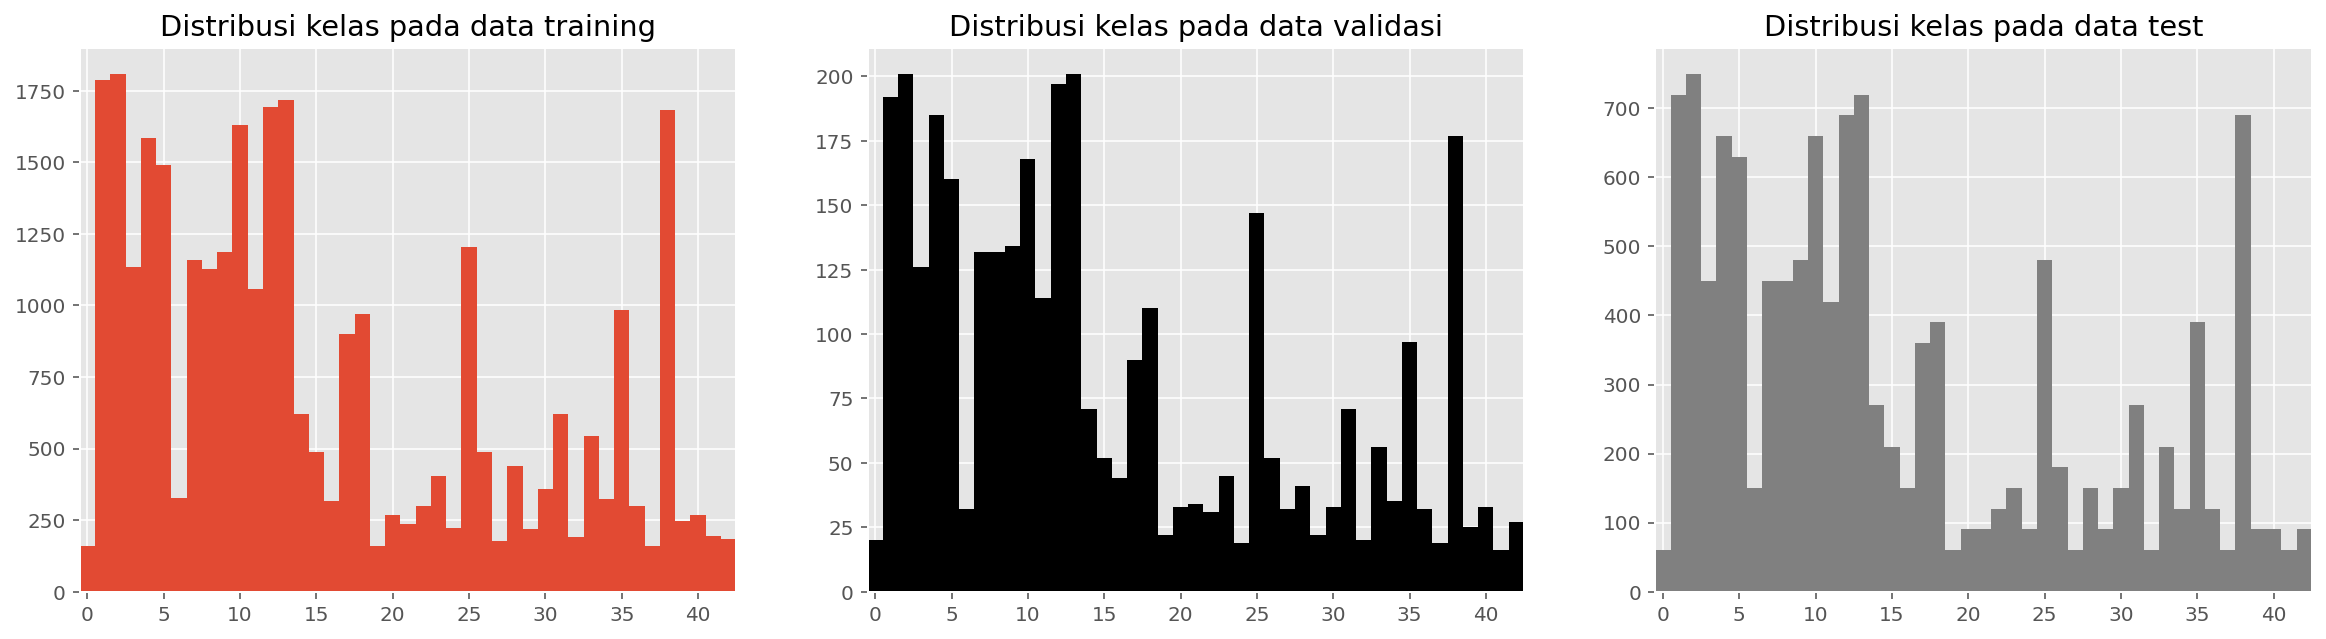

In [9]:
n_labels = np.unique(y_train).size
def hist_data(y_data, title=None, ax=None, **kwargs):
    if not ax :
        fig = plt.figure()
        ax = fig.add_subplot(111)
    ax.hist(y_data, np.arange(-0.5, n_labels+1.5), stacked=True, **kwargs)
    ax.set_xlim(-0.5, n_labels-0.5)
    if 'label' in kwargs : ax.legend()
    if title : ax.set_title(title)
        
fig,ax = plt.subplots(1,3, figsize=(20,5))
hist_data(y_train, title='Distribusi kelas pada data training', ax=ax[0])
hist_data(y_val, title='Distribusi kelas pada data validasi', ax=ax[1], color='black')
hist_data(y_test, title='Distribusi kelas pada data test', ax=ax[2], color='grey')

## **Data Preparation**
Pada tahap ini kita akan mengonversi label pada data training dan validasi dengan teknik one hot encoding. Tujuannya agar label, yang sebelumnya merupakan tipe data string menjadi fitur kategorik. Kita akan menggunakan fungsi to_categorical dari library tensorflow.

In [10]:
# Konversi label dengan teknik one hot encoding
from tensorflow.keras.utils import to_categorical
 
y_train = to_categorical(y_train, 43)
y_val = to_categorical(y_val, 43)

## **Training dengan Convolutional Neural Network**
Implementasi callback pada model. Set training berhenti saat akurasi model mencapai 96%. Penggunaan callback akan mempersingkat waktu training sebab kita sudah definisikan di awal berapa nilai akurasi yang dibutuhkan. Sehingga, saat model telah mencapai akurasi tersebut, proses training akan berhenti.

In [11]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('accuracy') > 0.96):
      print("\nAkurasi telah mencapai >96%. Stop training!")
      self.model.stop_training = True
callbacks = myCallback()

Set parameter layer pertama sebagai berikut:
*   Ukuran filter untuk proses konvolusi=32
*   Ukuran kernel=(5,5)
*   Fungsi aktivasi RELU
*   Pooling yang kita gunakan adalah Maxpool dengan ukuran 2,2
*   Dropout rate sebesar 0.25

In [12]:
model = Sequential()
model.add(Conv2D(filters=32, kernel_size=(5,5), activation='relu', input_shape=X_train.shape[1:]))
model.add(Conv2D(filters=32, kernel_size=(5,5), activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(rate=0.25))

Selanjutnya, untuk layer kedua, gunakan arsitektur sebagai berikut.

In [13]:
model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

Bagian fully connected layer beserta Output dari model summary.

In [15]:
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(43, activation='softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 32)        2432      
                                                                 
 conv2d_1 (Conv2D)           (None, 24, 24, 32)        25632     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 12, 12, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 12, 12, 32)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 10, 10, 64)        18496     
                                                                 
 conv2d_3 (Conv2D)           (None, 8, 8, 64)          36928     
                                                        

Melakukan kompilasi model dan memanggil fungsi fit untuk memulai training

In [19]:
# Compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
epochs = 25
history = model.fit(X_train, y_train, batch_size=32, epochs=epochs, validation_data=(X_val, y_val), callbacks=[callbacks])
model.save("my_model.h5")

Epoch 1/25
979/979 [==============================] - 185s 189ms/step - loss: 3.4790 - accuracy: 0.0568 - val_loss: 3.4840 - val_accuracy: 0.0578
Epoch 2/25
979/979 [==============================] - 179s 183ms/step - loss: 3.4792 - accuracy: 0.0568 - val_loss: 3.4837 - val_accuracy: 0.0578
Epoch 3/25
979/979 [==============================] - 173s 177ms/step - loss: 3.4786 - accuracy: 0.0575 - val_loss: 3.4834 - val_accuracy: 0.0578
Epoch 4/25
979/979 [==============================] - 170s 173ms/step - loss: 3.4794 - accuracy: 0.0567 - val_loss: 3.4833 - val_accuracy: 0.0552
Epoch 5/25
979/979 [==============================] - 170s 173ms/step - loss: 3.4793 - accuracy: 0.0556 - val_loss: 3.4830 - val_accuracy: 0.0552
Epoch 6/25
979/979 [==============================] - 170s 173ms/step - loss: 3.4788 - accuracy: 0.0575 - val_loss: 3.4831 - val_accuracy: 0.0578
Epoch 7/25
979/979 [==============================] - 169s 173ms/step - loss: 3.4789 - accuracy: 0.0576 - val_loss: 3.4826 -

Untuk mendapatkan grafik akurasi dan loss

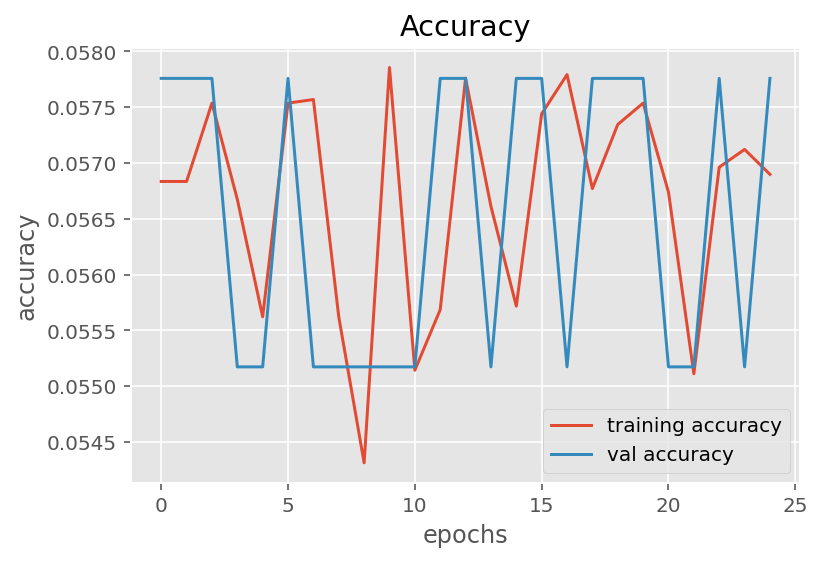

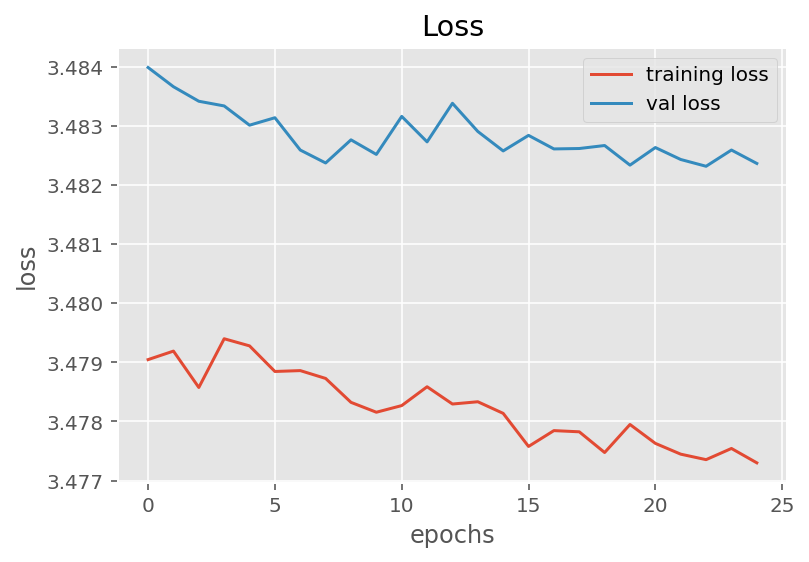

In [20]:
# Plotting graphs for accuracy 
plt.figure(0)
plt.plot(history.history['accuracy'], label='training accuracy')
plt.plot(history.history['val_accuracy'], label='val accuracy')
plt.title('Accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()
plt.show()
 
# Plotting graphs for loss
plt.figure(1)
plt.plot(history.history['loss'], label='training loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.title('Loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

## **Testing Model**

In [21]:
# Testing accuracy with the test data
from sklearn.metrics import accuracy_score
 
pred=np.argmax(model.predict(X_test), axis=-1)
accuracy_score(y_test, pred)

0.05938242280285035

Untuk memperoleh metrik klasifikasi lain seperti precision, recall, dan f1-score, Terapkan fungsi classification_report dari library sklearn. 

In [22]:
# Calculate metrics for classification
from sklearn.metrics import classification_report
 
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        60
           1       0.00      0.00      0.00       720
           2       0.06      1.00      0.11       750
           3       0.00      0.00      0.00       450
           4       0.00      0.00      0.00       660
           5       0.00      0.00      0.00       630
           6       0.00      0.00      0.00       150
           7       0.00      0.00      0.00       450
           8       0.00      0.00      0.00       450
           9       0.00      0.00      0.00       480
          10       0.00      0.00      0.00       660
          11       0.00      0.00      0.00       420
          12       0.00      0.00      0.00       690
          13       0.00      0.00      0.00       720
          14       0.00      0.00      0.00       270
          15       0.00      0.00      0.00       210
          16       0.00      0.00      0.00       150
          17       0.00    

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
